# Projet 6 :

# Classification supervisée

### Chargement des bibliothèques et des données

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


In [22]:
# Chargement des données df
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [23]:
folder_path = "/Users/azizi/Desktop/Flipkart/Images/"

# Create an empty DataFrame for the image paths and labels
image_df = pd.DataFrame(columns=['ImagePath', 'Label'])

for index, row in df.iterrows():
    image_name = row['image']
    label = row['product_category_tree']
    image_path = os.path.join(folder_path, image_name)
    image_df.loc[index] = [image_path, label]

image_df['categorie'] = image_df['Label'].apply(lambda x: str(x).split(">>")[0][2:])

image_df

,ImagePath,Label,categorie
0,/Users/azizi/Desktop/Flipkart/Images/55b85ea15...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,/Users/azizi/Desktop/Flipkart/Images/7b72c92c2...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,/Users/azizi/Desktop/Flipkart/Images/64d5d4a25...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
3,/Users/azizi/Desktop/Flipkart/Images/d4684dcdc...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
4,/Users/azizi/Desktop/Flipkart/Images/6325b6870...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
...,...,...,...
1045,/Users/azizi/Desktop/Flipkart/Images/958f54f4c...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1046,/Users/azizi/Desktop/Flipkart/Images/fd6cbcc22...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1047,/Users/azizi/Desktop/Flipkart/Images/5912e037d...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1048,/Users/azizi/Desktop/Flipkart/Images/c3edc504d...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care


In [24]:
# Importer le module de prétraitement des données
from sklearn import preprocessing

# Créer une instance du LabelEncoder
le = preprocessing.LabelEncoder()

# Adapter le LabelEncoder aux étiquettes 
le.fit(image_df["categorie"])

# Transformer les étiquettes 
image_df["label"] = le.transform(image_df["categorie"])

# Afficher les 5 premières lignes du DataFrame "image_df" avec la nouvelle colonne "label"
image_df.head(5)


,ImagePath,Label,categorie,label
0,/Users/azizi/Desktop/Flipkart/Images/55b85ea15...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing,4
1,/Users/azizi/Desktop/Flipkart/Images/7b72c92c2...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,0
2,/Users/azizi/Desktop/Flipkart/Images/64d5d4a25...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,0
3,/Users/azizi/Desktop/Flipkart/Images/d4684dcdc...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,4
4,/Users/azizi/Desktop/Flipkart/Images/6325b6870...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,4


In [25]:
image_df = image_df.drop("Label", axis=1)
image_df

,ImagePath,categorie,label
0,/Users/azizi/Desktop/Flipkart/Images/55b85ea15...,Home Furnishing,4
1,/Users/azizi/Desktop/Flipkart/Images/7b72c92c2...,Baby Care,0
2,/Users/azizi/Desktop/Flipkart/Images/64d5d4a25...,Baby Care,0
3,/Users/azizi/Desktop/Flipkart/Images/d4684dcdc...,Home Furnishing,4
4,/Users/azizi/Desktop/Flipkart/Images/6325b6870...,Home Furnishing,4
...,...,...,...
1045,/Users/azizi/Desktop/Flipkart/Images/958f54f4c...,Baby Care,0
1046,/Users/azizi/Desktop/Flipkart/Images/fd6cbcc22...,Baby Care,0
1047,/Users/azizi/Desktop/Flipkart/Images/5912e037d...,Baby Care,0
1048,/Users/azizi/Desktop/Flipkart/Images/c3edc504d...,Baby Care,0


In [27]:
from sklearn.model_selection import train_test_split
import pandas as pd
from glob import glob
from sklearn import preprocessing

train_data, test_data = train_test_split(image_df, test_size=0.25, random_state=42, shuffle=False)

# Sélectionner un échantillon aléatoire de 75% des données avec remplacement
#image_data = image_df.sample(frac=0.75, replace=True, random_state=1)

# Créer un nouvel ensemble de données contenant les données restantes (25%) qui n'ont pas été échantillonnées
#test_data = image_df.drop(image_data.index)


In [28]:
test_data.head(5)

,ImagePath,categorie,label
787,/Users/azizi/Desktop/Flipkart/Images/7264f5663...,Watches,6
788,/Users/azizi/Desktop/Flipkart/Images/b5aafdb7c...,Watches,6
789,/Users/azizi/Desktop/Flipkart/Images/389197b67...,Baby Care,0
790,/Users/azizi/Desktop/Flipkart/Images/75549ef6a...,Watches,6
791,/Users/azizi/Desktop/Flipkart/Images/4676a8f96...,Beauty and Personal Care,1


In [29]:
test_data.shape

(263, 3)

# Classification supervisée

## Approche préparation initiale des images

In [30]:
def image_prep_fct(data):
    prepared_images = []
    for image_path in data['ImagePath']:
        img = load_img(
            image_path,
            target_size=(224, 224)
        )
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

# Données d'entraînement
images_np = image_prep_fct(train_data)
print(images_np.shape)

# Données de test
images_np_test = image_prep_fct(test_data)
print(images_np_test.shape)


/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(787, 224, 224, 3)
(263, 224, 224, 3)


In [31]:
images_np

array([[[[  88.061   ,   87.221   ,   82.32    ],
         [  87.061   ,   86.221   ,   81.32    ],
         [  89.061   ,   85.221   ,   81.32    ],
         ...,
         [  53.060997,   49.221   ,   51.32    ],
         [  54.060997,   50.221   ,   52.32    ],
         [  53.060997,   49.221   ,   51.32    ]],

        [[  99.061   ,   91.221   ,   83.32    ],
         [  97.061   ,   89.221   ,   83.32    ],
         [  98.061   ,   90.221   ,   84.32    ],
         ...,
         [  56.060997,   52.221   ,   54.32    ],
         [  54.060997,   50.221   ,   52.32    ],
         [  55.060997,   51.221   ,   53.32    ]],

        [[  99.061   ,   90.221   ,   84.32    ],
         [ 103.061   ,   92.221   ,   86.32    ],
         [ 103.061   ,   92.221   ,   86.32    ],
         ...,
         [  55.060997,   51.221   ,   53.32    ],
         [  56.060997,   52.221   ,   54.32    ],
         [  53.060997,   49.221   ,   51.32    ]],

        ...,

        [[  25.060997,   37.221   ,   

In [33]:
X = images_np
y = to_categorical(train_data['label'])

X_test = images_np_test
y_test = to_categorical(test_data['label'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(590, 224, 224, 3)

In [35]:
X_val.shape

(197, 224, 224, 3)

In [36]:
X_test.shape

(263, 224, 224, 3)

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

def create_model():
    # Charger le modèle pré-entraîné VGG16 sans les couches supérieures (entièrement connectées)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Geler les couches du modèle de base pour empêcher leur entraînement
    for layer in base_model.layers:
        layer.trainable = False

    # Créer un nouveau modèle séquentiel au-dessus du modèle de base
    model = models.Sequential()

    # Ajouter le modèle de base VGG16
    model.add(base_model)

    # Aplatir les sorties en un vecteur 1D
    model.add(layers.Flatten())

    # Ajouter une couche Dense avec 512 neurones et activation ReLU
    model.add(layers.Dense(512, activation='relu'))

    # Appliquer la régularisation Dropout avec un taux de 0.5
    model.add(layers.Dropout(0.5))

    # Ajouter une autre couche Dense avec 256 neurones et activation ReLU
    model.add(layers.Dense(256, activation='relu'))

    # Appliquer à nouveau la régularisation Dropout avec un taux de 0.5
    model.add(layers.Dropout(0.5))

    # Ajouter la couche de sortie Dense avec 7 neurones pour la classification (activation softmax)
    model.add(layers.Dense(7, activation='softmax')) 

    # Compiler le modèle avec l'optimiseur RMSprop, une faible valeur d'apprentissage (lr=1e-3), 
    # la fonction de perte categorical_crossentropy et la métrique d'évaluation accuracy
    model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Afficher un résumé détaillé du modèle, montrant l'architecture et le nombre de paramètres entraînables
    model.summary()

    return model


In [38]:
# Création du modèle
with tf.device('/gpu:0'): 
    model = create_model()

# Création du callback
model_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                

## Optimisation des hyperparamètres

In [51]:
# Déterminer le nombre d'étapes par époque en fonction de la taille du lot
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=50, batch_size = 32, steps_per_epoch = len(X_train) // 32,
                        validation_steps = len(X_val) // 32,
                        callbacks=callbacks_list, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 17.9852 - accuracy: 0.7431 
Epoch 1: val_loss did not improve from 11.82668
18/18 [==============================] - 395s 23s/step - loss: 17.9852 - accuracy: 0.7431 - val_loss: 29.8144 - val_accuracy: 0.4896
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 15.2031 - accuracy: 0.7796 
Epoch 2: val_loss did not improve from 11.82668
18/18 [==============================] - 410s 24s/step - loss: 15.2031 - accuracy: 0.7796 - val_loss: 13.1352 - val_accuracy: 0.7188
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 11.7748 - accuracy: 0.8011  
Epoch 3: val_loss did not improve from 11.82668
18/18 [==============================] - 4322s 253s/step - loss: 11.7748 - accuracy: 0.8011 - val_loss: 18.0927 - val_accuracy: 0.6094
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 7.7907 - accuracy: 0.8656  
Epoch 4: val_loss did not improve from 11.82668
18/18 [===============

In [52]:
!pip install plot_keras_history

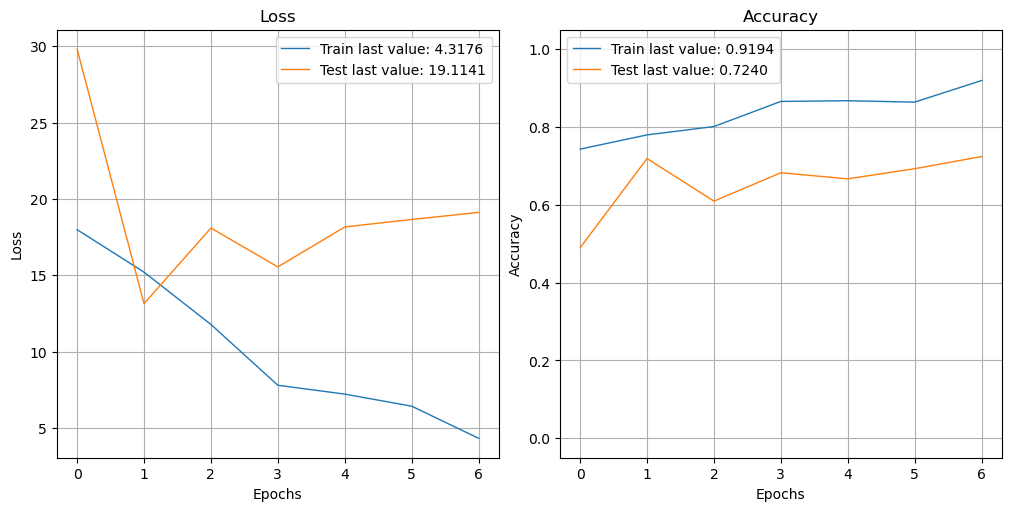

In [53]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [54]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 116s 16s/step
[2 3 5 5 4 6 0 0 1 5 4 2 6 5 3 1 0 3 2 6 5 5 0 0 1 6 6 4 1 6 1 6 0 5 1 1 0
 3 4 6 0 5 1 4 3 5 2 1 4 5 2 4 1 4 2 5 5 0 2 1 1 1 5 6 6 3 1 2 0 3 0 0 0 6
 5 2 2 2 1 0 6 6 3 3 5 1 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 5 2 6 6 2 1 3
 3 2 6 3 1 3 3 3 4 3 4 2 3 4 5 3 6 6 2 4 6 4 2 6 6 6 0 6 0 5 1 4 1 2 0 6 4
 4 5 1 5 0 5 4 0 5 5 3 6 6 0 3 3 2 6 0 6 5 3 0 5 2 6 0 4 1 3 4 1 5 6 5 5 1
 1 3 5 3 5 5 0 3 1 0 5 6]

[2 3 1 5 4 6 0 4 1 0 4 2 6 5 3 1 0 6 2 6 5 5 4 0 4 6 6 4 1 6 1 6 0 5 1 1 0
 1 4 6 0 5 1 3 3 5 2 1 4 5 2 4 1 4 2 3 5 0 2 6 1 6 5 6 6 3 1 2 0 3 1 4 4 6
 5 2 2 2 1 0 6 6 3 3 5 1 2 4 2 6 1 2 6 6 2 2 1 3 0 5 6 6 1 5 5 1 6 6 2 1 3
 3 4 6 3 1 2 6 4 4 2 4 2 3 4 5 3 6 6 2 4 6 4 2 6 6 6 0 6 0 5 1 0 1 2 0 6 4
 4 5 1 5 0 5 4 2 5 1 3 6 6 1 3 3 2 6 0 6 5 3 0 5 1 6 0 4 2 3 1 1 5 6 5 3 1
 5 3 3 3 5 5 0 3 2 0 5 6]


In [55]:
from sklearn import metrics

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[19  2  1  0  5  0  0]
 [ 0 23  2  0  1  1  2]
 [ 0  2 22  0  1  0  0]
 [ 0  1  2 21  1  0  2]
 [ 1  1  0  1 16  0  0]
 [ 1  2  0  3  0 28  1]
 [ 0  0  0  0  0  0 35]]


In [56]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [57]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[19  2  1  0  5  0  0]
 [ 0 23  2  0  1  1  2]
 [ 0  2 22  0  1  0  0]
 [ 0  1  2 21  1  0  2]
 [ 1  1  0  1 16  0  0]
 [ 1  2  0  3  0 28  1]
 [ 0  0  0  0  0  0 35]]

              precision    recall  f1-score   support

           0       0.90      0.70      0.79        27
           1       0.74      0.79      0.77        29
           2       0.81      0.88      0.85        25
           3       0.84      0.78      0.81        27
           4       0.67      0.84      0.74        19
           5       0.97      0.80      0.88        35
           6       0.88      1.00      0.93        35

    accuracy                           0.83       197
   macro avg       0.83      0.83      0.82       197
weighted avg       0.84      0.83      0.83       197



<AxesSubplot:>

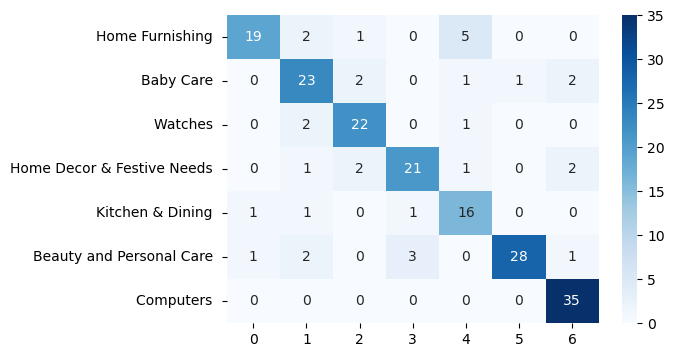

In [58]:
list_labels = image_df['categorie'].unique()
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [59]:
# Enregistrez le DataFrame en tant que fichier csv à l'aide de la méthode to_csv() 
image_df.to_csv('image_df.csv', index=False)